In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train BaggingClassifier as the ensemble model
meta_learner_bagging = BaggingClassifier(
    n_estimators=50,            # Number of base models
    max_samples=0.8,            # Fraction of the dataset for each model
    max_features=0.8,           # Fraction of features for each model
    bootstrap=True,             # Whether to bootstrap samples
    random_state=42             # For reproducibility
)
meta_learner_bagging.fit(stacked_features, y_test)

# Save the trained Bagging meta-learner
with open('meta_learner_bagging.pkl', 'wb') as file:
    pickle.dump(meta_learner_bagging, file)

# Predict using the Bagging meta-learner
final_predictions_bagging = meta_learner_bagging.predict(stacked_features)

# Evaluate the Bagging ensemble model
accuracy_bagging = accuracy_score(y_test, final_predictions_bagging)
report_bagging = classification_report(y_test, final_predictions_bagging, target_names=label_encoder.classes_)

print(f"Bagging Meta-Learner Accuracy: {accuracy_bagging * 100:.2f}%")
print("Classification Report (Bagging):\n", report_bagging)
print("Confusion Matrix (Bagging):\n", confusion_matrix(y_test, final_predictions_bagging))


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invali

581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Bagging Meta-Learner Accuracy: 99.76%
Classification Report (Bagging):
               precision    recall  f1-score   support

     anxiety       1.00      1.00      1.00      1999
     bipolar       0.99      0.99      0.99      1941
  depression       1.00      1.00      1.00      1959
      normal       1.00      1.00      1.00     10679
        ptsd       1.00      1.00      1.00      1987

    accuracy                           1.00     18565
   macro avg       1.00      1.00      1.00     18565
weighted avg       1.00      1.00      1.00     18565

Confusion Matrix (Bagging):
 [[ 1992     2     3     0     2]
 [    2  1925     4    10     0]
 [    5     2  1951     0     1]
 [    1    10     0 10667     1]
 [    1     0     1     0  1985]]


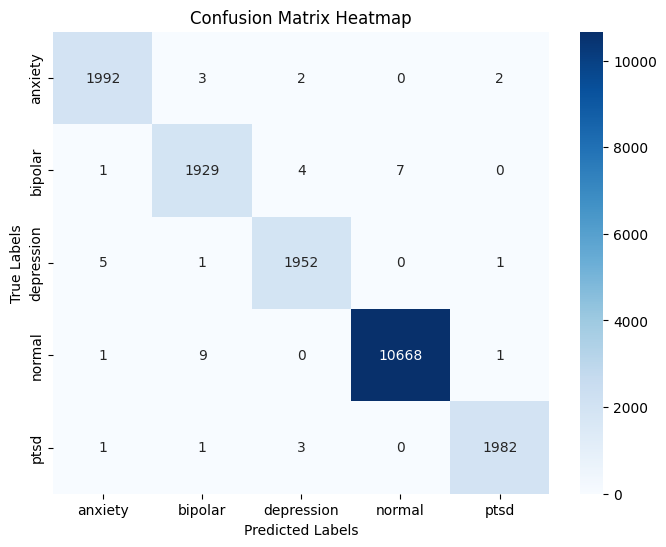

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, final_predictions_bagging)
class_labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


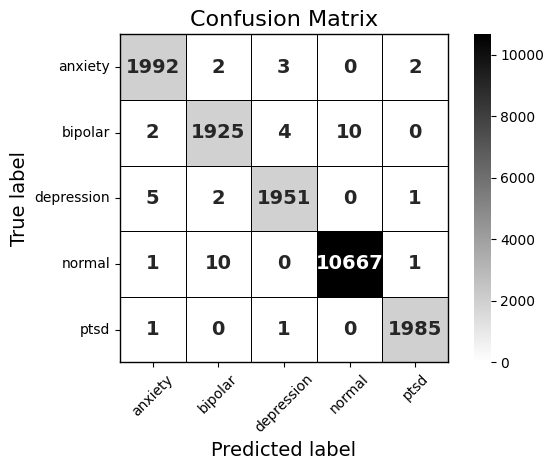

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, final_predictions_bagging)
class_labels = label_encoder.classes_

ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='gist_yarg',         # grayscale colormap with deep tones ( gist_yarg )
    cbar=True,                # color bar for value reference
    cbar_kws={'label': ''},
    annot_kws={'size':14, 'weight':'bold'},
    linewidths=0.5,           # thinner borders
    linecolor='black',
    square=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)

# Fix bottom and right border visibility
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



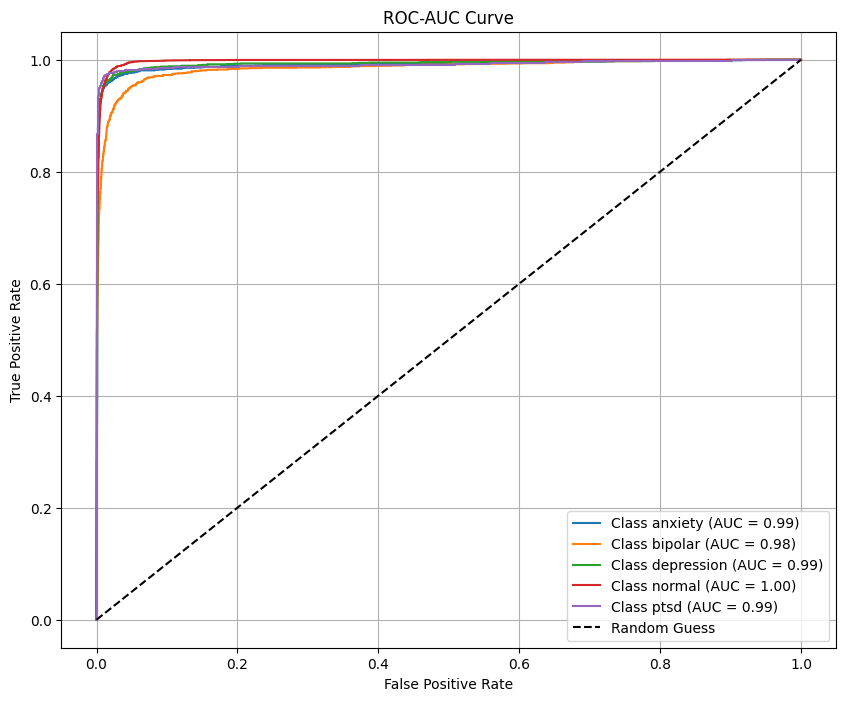

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC-AUC computation
y_test_binarized = label_binarize(y_test, classes=range(len(class_labels)))

# Initialize plot
plt.figure(figsize=(10, 8))

# Generate ROC curves for each class
for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# FINAL AFTER CROSS VALIDATION AND TRAIN TEST SPLIT

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X = data['cleaned_text']
y = data['mental_health_issue']
y = label_encoder.transform(y)

# Preprocess the text
X_lr = lr_vectorizer.transform(X)
X_svm = svm_vectorizer.transform(X)
X_nb = nb_vectorizer.transform(X)
X_xgb = tfidf_vectorizer.transform(X)
X_lstm = lstm_tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_lr)
svm_predictions_proba = svm_model.predict_proba(X_svm)
nb_predictions_proba = nb_model.predict_proba(X_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_xgb)
lstm_predictions_proba = lstm_model.predict(X_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    stacked_features, y, test_size=0.2, random_state=42, stratify=y
)

# Train BaggingClassifier as the meta-learner
meta_learner_bagging = BaggingClassifier(
    n_estimators=50,             # Number of base models
    max_samples=0.8,             # Fraction of the dataset for each base model
    max_features=0.8,            # Fraction of features for each base model
    bootstrap=True,              # Whether to bootstrap samples
    random_state=42              # For reproducibility
)

# Fit the model on the training data
meta_learner_bagging.fit(X_train, y_train)

# Predict on the test set
test_predictions_bagging = meta_learner_bagging.predict(X_test)

# Evaluate the Bagging ensemble model
test_accuracy_bagging = accuracy_score(y_test, test_predictions_bagging)
report_bagging = classification_report(y_test, test_predictions_bagging, target_names=label_encoder.classes_)

print(f"Bagging Meta-Learner Test Accuracy: {test_accuracy_bagging * 100:.2f}%")
print("Classification Report (Test Set):\n", report_bagging)
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, test_predictions_bagging))

# Save the trained Bagging meta-learner
with open('meta_learner_bagging.pkl', 'wb') as file:
    pickle.dump(meta_learner_bagging, file)

# Perform cross-validation to calculate mean and standard deviation of validation accuracies
cross_val_accuracies = cross_val_score(
    meta_learner_bagging, stacked_features, y, cv=5, scoring='accuracy'
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invali

581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Bagging Meta-Learner Test Accuracy: 97.39%
Classification Report (Test Set):
               precision    recall  f1-score   support

     anxiety       0.97      0.97      0.97       400
     bipolar       0.94      0.90      0.92       388
  depression       0.96      0.94      0.95       392
      normal       0.98      0.99      0.99      2136
        ptsd       0.97      0.97      0.97       397

    accuracy                           0.97      3713
   macro avg       0.96      0.96      0.96      3713
weighted avg       0.97      0.97      0.97      3713

Confusion Matrix (Test Set):
 [[ 389    1    5    2    3]
 [   2  351    5   26    4]
 [   9    7  370    2    4]
 [   0   13    1 2121    1]
 [   2    2    3    5  385]]
Cross-Validation Accuracies: [0.97549152 0.96283329 0.97629949 0.96471856 0.97091301]
Mean Validation Accuracy: 97.01%
Validation Accuracy Std Dev: 0.55%


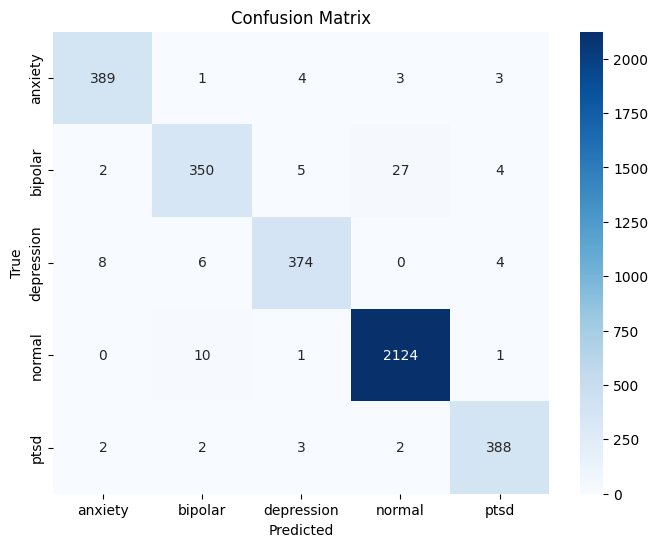

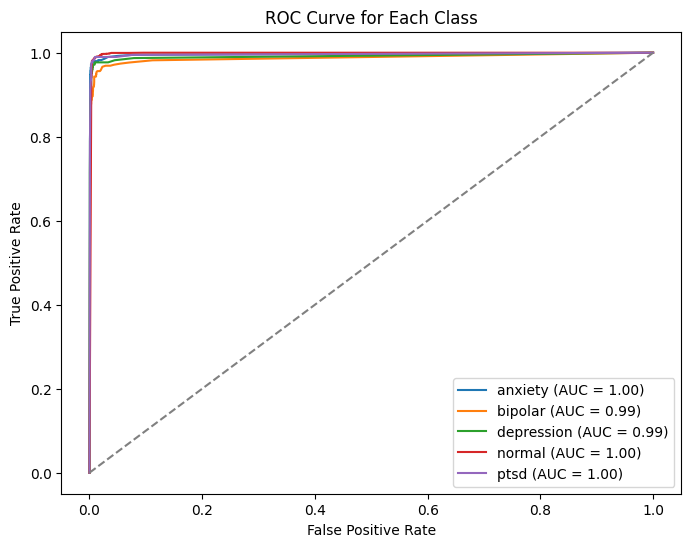

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Evaluate the Random Forest ensemble model
test_accuracy_rf = accuracy_score(y_test, test_predictions_bagging)
report_rf = classification_report(y_test, test_predictions_bagging, target_names=label_encoder.classes_)


# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Curve
# Calculate the probability scores for the test set
y_pred_proba_rf = meta_learner_bagging.predict_proba(X_test)

# Create ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


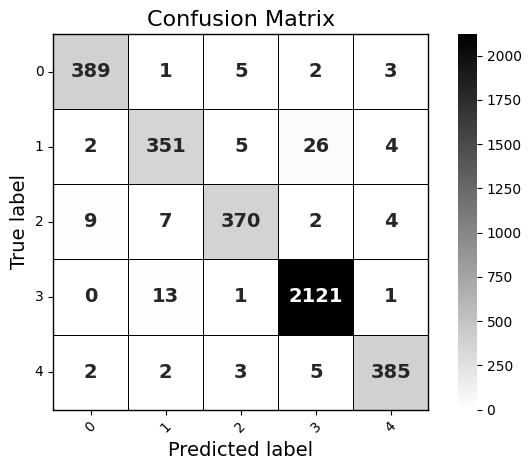

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Evaluate the Random Forest ensemble model
test_accuracy_rf = accuracy_score(y_test, test_predictions_bagging)
report_rf = classification_report(y_test, test_predictions_bagging, target_names=label_encoder.classes_)

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions_bagging)

ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='gist_yarg',         # grayscale colormap with deep tones ( gist_yarg )
    cbar=True,                # color bar for value reference
    cbar_kws={'label': ''},
    annot_kws={'size':14, 'weight':'bold'},
    linewidths=0.5,           # thinner borders
    linecolor='black',
    square=True,
    #xticklabels=label_encoder.classes_,
    #yticklabels=label_encoder.classes_
)

# Fix bottom and right border visibility
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


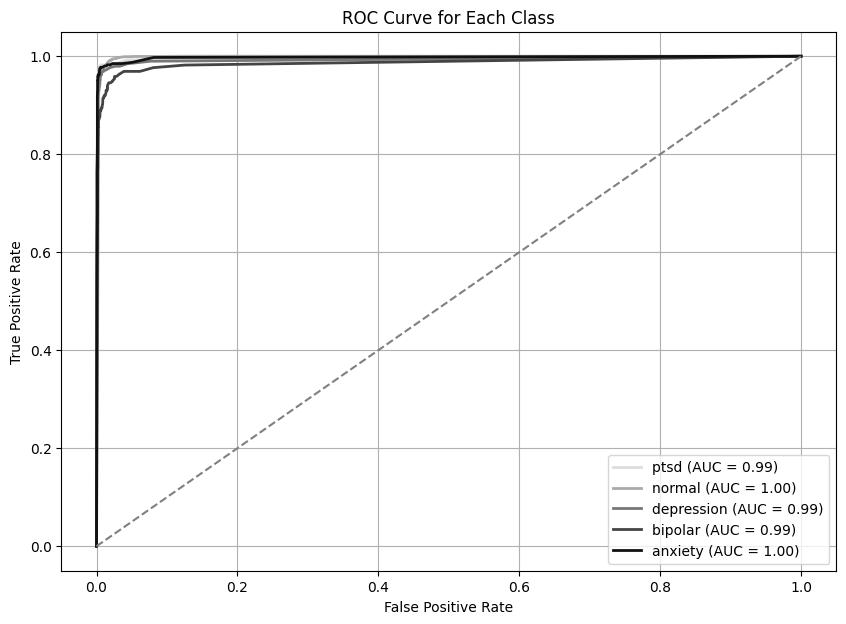

In [9]:
# ROC AUC Curve using Grey Shades (Reversed Loop)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define grey shades
greys = ['#111111', '#444444', '#777777', '#AAAAAA', '#DDDDDD']

# Calculate the probability scores for the test set
y_pred_proba_rf = meta_learner_bagging.predict_proba(X_test)

# Create ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class in reverse order
plt.figure(figsize=(10, 7))

for i in reversed(range(len(label_encoder.classes_))):
    color = greys[i % len(greys)]  # Use grey shades cyclically
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
